### **Project Showcase - Depression Detection using Twitter Data**

The preprocessing section was inspired by code from this article - https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

In [3]:
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

ModuleNotFoundError: No module named 'torchtext'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
import os, sys
import re
import string
import itertools

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Pandas version: 0.24.2
Pytorch version: 1.1.0
Torch Text version: 0.3.1
Spacy version: 2.1.8


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
!ls "/content/gdrive/My Drive/embedding"

glove.6B.100d.txt  glove.twitter.27B.100d.txt	  uncased_L-12_H-768_A-12.zip
glove.6B.200d.txt  glove.twitter.27B.100d.txt.pt


# **0. Assemble Data**





In [12]:
!ls "/content/gdrive/My Drive/data"

 dataset_al12.csv      dataset_en_all7.csv	  tweets_final_1.csv
 dataset_al1.csv       dataset_v2.csv		  tweets_final_2_clean.csv
 dataset_all1.csv      food			  tweets_final_2.csv
 dataset_all.csv       imdb			 'tweets_final_3 (1).gsheet'
 dataset_en_al12.csv   sentiment_tweets3.csv	  tweets_final_3_clean.csv
 dataset_en_al18.csv   sequences.npy		  tweets_final_3.csv
 dataset_en_al19.csv   test.csv			  tweets_final_3.gsheet
 dataset_en_all1.csv   test.csv.zip		  tweets_final.csv
 dataset_en_all3.csv   train.csv.zip		  tweets_v2.csv
 dataset_en_all4.csv   train_df.pkl		  tweets_v2.gsheet
 dataset_en_all5.csv   tweet			  users_list.csv
 dataset_en_all6.csv   tweets_final_1_clean.csv


In [ ]:
df1 = pd.read_csv("/content/gdrive/My Drive/data/tweets_final_1_clean.csv", engine='python')
df2 = pd.read_csv("/content/gdrive/My Drive/data/tweets_final_2_clean.csv", engine='python')
df3 = pd.read_csv("/content/gdrive/My Drive/data/tweets_final_3_clean.csv", engine='python')

In [19]:
df1.target.value_counts()

1    216
0     97
Name: target, dtype: int64

In [ ]:
df = pd.concat([df1, df2, df3])

## **1. Load Data**

In [ ]:
# df = pd.read_csv("/content/gdrive/My Drive/data/sentiment_tweets3.csv")

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [23]:
df.head()

,Unnamed: 0,id,conversation_id,date,username,tweet_processed,hashtags,tweet_original,target
0,1,1.163051e+18,1.163051e+18,2019-08-18,lowerdepression,"mood can be caused by infectious diseases, nutritional deficiencies, neurological conditions, and physiological problems.",['#depressed'],"#Depressed mood can be caused by infectious diseases, nutritional deficiencies, neurological conditions, and physiological problems.",1
1,6,1.163030e+18,1.163030e+18,2019-08-18,chrisbontheweb,"With all of this unnessary family drama, I feel like moving far away and starting over again. From one thing to another I just feel . Hope I get through this",['#depressed'],"With all of this unnessary family drama, I feel like moving far away and starting over again. From one thing to another I just feel #depressed. Hope I get through this",1
2,11,1.163020e+18,1.163020e+18,2019-08-18,wildfoxtherapy,"I'm going to keep banging on about this, cos it's true. What you focus on, you get more of. Stop telling yourself you're or . Tell yourself you're happy, strong, confident, powerful. Not only cos you ARE, but cos your brilliant mind listens to what you tell it. pic.twitter.com/gBQn7yEjsJ","['#depressed', '#anxious']","I'm going to keep banging on about this, cos it's true. What you focus on, you get more of. Stop telling yourself you're #depressed or #anxious. Tell yourself you're happy, strong, confident, powerful. Not only cos you ARE, but cos your brilliant mind listens to what you tell it. pic.twitter.com/gBQn7yEjsJ",0
3,14,1.163011e+18,1.163011e+18,2019-08-18,simonblue16,Ugh. Woke up to the same acne covered face this morning... Yyayyy????,"['#skin', '#sundaythoughts', '#depressed']",Ugh. Woke up to the same acne covered face this morning... Yyayyy???? #skin #SundayThoughts #depressed,0
4,16,1.163002e+18,1.163002e+18,2019-08-18,puffpuffnpass1,Portable Transparent Tobacco Rolling Machine pic.twitter.com/k7Sb0Q11fW,"['#stoner', '#instahookah', '#depressed']",#stoner #instahookah #depressed Portable Transparent Tobacco Rolling Machine pic.twitter.com/k7Sb0Q11fW,0


In [25]:
df.target.value_counts()

1    508
0    446
Name: target, dtype: int64

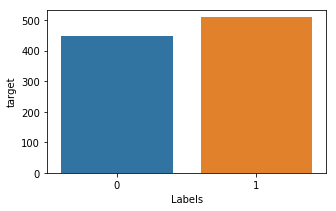

In [27]:
fig = plt.figure(figsize=(5,3))
ax = sns.barplot(x=df.target.unique(),y=df.target.value_counts());
ax.set(xlabel='Labels');

In [115]:
df1.tweet_processed.head(20), df1.tweet_processed.tail(20)

(0      mood can be caused by infectious diseases, nutritional deficiencies, neurological conditions, and physiological problems.                                                                                                                                                                       
 1     With all of this unnessary  family drama, I feel like moving far away and starting over again. From one thing to another I just feel . Hope I get through this                                                                                                                                   
 2     I'm going to keep banging on about this, cos it's true. What you focus on, you get more of. Stop telling yourself you're  or . Tell yourself you're happy, strong, confident, powerful. Not only cos you ARE, but cos your brilliant mind listens to what you tell it. pic.twitter.com/gBQn7yEjsJ
 3     Ugh. Woke up to the same acne covered face this morning... Yyayyy????                                 

In [41]:
# check non-depressive tweets
df[df["target"]==0].iloc[:10, 5]

2     I'm going to keep banging on about this, cos it's true. What you focus on, you get more of. Stop telling yourself you're  or . Tell yourself you're happy, strong, confident, powerful. Not only cos you ARE, but cos your brilliant mind listens to what you tell it. pic.twitter.com/gBQn7yEjsJ
3     Ugh. Woke up to the same acne covered face this morning... Yyayyy????                                                                                                                                                                                                                            
4     Portable Transparent Tobacco Rolling Machine  pic.twitter.com/k7Sb0Q11fW                                                                                                                                                                                                                         
5     Certain medications are known to cause  mood in a significant number of patients.                         

In [43]:
# check depressive tweets
df[df["target"]==1].iloc[:10, 5]

0      mood can be caused by infectious diseases, nutritional deficiencies, neurological conditions, and physiological problems.                                                                                                                                
1     With all of this unnessary  family drama, I feel like moving far away and starting over again. From one thing to another I just feel . Hope I get through this                                                                                            
6     I feel so sad because i can't be happy, and that makes me more unhappy                                                                                                                                                                                    
7     I went to church with my mom and a huge chunk of the sermon was basically �if you�re  it�s because your faith is weak� and ... this is why I don�t go to church or tell my mom I�m on antidepressants ???????                  

## **2. Define How to Preprocess Data**

In [44]:
# torchtext have trouble handling \n. Replace \n character with space
df['tweet_processed'] = df.tweet_processed.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|██████████| 954/954 [00:00<00:00, 115760.17it/s]


In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [ ]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [ ]:
def tweet_clean(text):
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove urls
    text = re.sub(r'<([^>]*)>', ' ', text) # remove emojis
    text = re.sub(r'@\w+', ' ', text) # remove at mentions
    text = re.sub(r'#\w+', ' ', text) # remove hashtags   
    text = re.sub(r'[0-9]+', ' ', text) # remove numbers
    text = replace_contractions(text)
    pattern = re.compile(r"[ \n\t]+")
    text = pattern.sub(" ", text)      
    text = "".join("".join(s)[:2] for _, s in itertools.groupby(text))    
    text = re.sub(r'[^A-Za-z0-9,?.!]+', ' ', text) # remove all symbols and punctuation except for . , ! and ?
    return text.strip()

In [ ]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

**Define fields**

In [ ]:
TEXT = Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
TARGET = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None, is_target =False)

In [ ]:
data_fields = [
    (None, None),
    (None, None),
    (None, None),
    (None, None),
    (None, None),
    ("tweet_processed", TEXT), 
    (None, None),
    (None, None),
    ("target", TARGET)
]

## **3. Create Train, Valid and Test datasets**

In [ ]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [ ]:
# create train and validation set 
train_val, test = split_train_test(df, test_size=0.2)
train, val = split_train_test(train_val, test_size=0.2)

In [ ]:
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

In [72]:
train.shape, val.shape, test.shape

((610, 9), (153, 9), (191, 9))

[Text(0, 0.5, 'counts'), Text(0.5, 0, 'Labels'), Text(0.5, 1.0, 'test')]

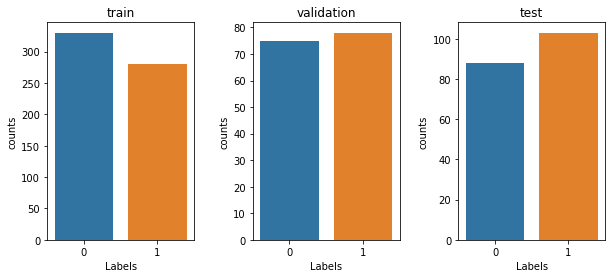

In [73]:
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1,3,1)
ax = sns.barplot(x=train.target.unique(),y=train.target.value_counts())
ax.set(xlabel='Labels', ylabel="counts", title="train")

ax1 = fig.add_subplot(1,3,2)
ax1 = sns.barplot(x=val.target.unique(),y=val.target.value_counts())
ax1.set(xlabel='Labels', ylabel="counts", title="validation")

ax2 = fig.add_subplot(1,3,3)
ax2 = sns.barplot(x=test.target.unique(),y=test.target.value_counts())
ax2.set(xlabel='Labels', ylabel="counts", title="test")

In [74]:
%%time
train_data, val_data, test_data = TabularDataset.splits(path='./', format='csv', train='train.csv', validation='val.csv', test='test.csv', fields=data_fields, skip_header=True)

CPU times: user 598 ms, sys: 436 µs, total: 598 ms
Wall time: 600 ms


In [75]:
len(train_data), len(val_data), len(test_data)

(610, 153, 191)

In [76]:
print(vars(train_data[0]))

{'tweet_processed': ['i', 'strongly', 'believe', 'in', 'there', 'if', 'for', 'everyone', '.', 'i', 'have', 'not', 'met', 'it', 'yet', '.'], 'target': '0'}


## **4. Load pretrained embeddings and build vocab**

In [77]:
!ls '/content/gdrive/My Drive/embedding'

glove.6B.100d.txt  glove.twitter.27B.100d.txt	  uncased_L-12_H-768_A-12.zip
glove.6B.200d.txt  glove.twitter.27B.100d.txt.pt


In [78]:
%%time
vec = torchtext.vocab.Vectors('glove.twitter.27B.100d.txt', '/content/gdrive/My Drive/embedding')

CPU times: user 530 ms, sys: 506 ms, total: 1.04 s
Wall time: 1.21 s


In [79]:
%%time
MAX_VOCAB_SIZE = 80_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors=vec)

TARGET.build_vocab(train_data)

CPU times: user 52.3 ms, sys: 589 µs, total: 52.9 ms
Wall time: 56.3 ms


In [80]:
print(TEXT.vocab.stoi['the'])

7


In [81]:
print(TEXT.vocab.itos[:20])

['<unk>', '<pad>', '?', '.', 'i', 'to', ',', 'the', 'and', 'a', 'you', 'not', 'is', 'my', 'it', 'of', '..', 'in', 'for', 'so']


In [82]:
TEXT.vocab.vectors.shape

torch.Size([2330, 100])

In [83]:

TEXT.vocab.vectors[TEXT.vocab.stoi['the']]

tensor([ 9.5152e-02,  3.7024e-01,  5.4291e-01,  1.9621e-01,  4.8205e-02,
         3.2033e-01, -5.9638e-01,  1.5868e-02, -1.2989e-01, -6.3028e-01,
         8.1944e-02,  2.4164e-01, -6.0990e+00, -6.8557e-01,  5.0354e-01,
        -3.4089e-02,  1.1705e-01, -7.7403e-03, -8.6512e-02,  4.3617e-01,
        -4.3982e-01,  2.6125e-01, -4.0348e-02, -1.9194e-01,  8.3204e-02,
        -5.8246e-01, -3.1923e-02,  1.2630e-01,  4.0120e-01,  6.8906e-02,
        -1.0517e-01, -2.0804e-01, -4.2554e-01,  4.7799e-01,  3.4651e-01,
         2.4057e-01,  5.0244e-02, -7.2587e-02, -2.4347e-03, -5.0342e-01,
        -1.0601e+00, -3.1586e-01, -3.2457e-02, -7.6317e-02,  7.9045e-01,
         8.6367e-02, -1.9632e-01,  5.7566e-02,  8.4129e-01, -4.2020e-01,
        -1.1335e-03, -8.5632e-02,  6.1910e-02,  2.1423e-01, -1.0356e-01,
        -3.6946e-02, -2.6005e-01, -3.5657e-01,  5.4321e-02,  3.0875e-02,
         1.4092e-01, -9.1998e-02, -4.1841e-01, -3.1135e-01, -1.4937e-01,
        -2.2699e-04, -3.3454e-01, -1.4848e-01, -1.1

In [84]:
train_data

## **5. Load data in batches**

We will use the BucketIterator to access the Dataloader. It sorts data according to length of text, and groups similar length text in a batch, thus reducing the amount of padding required. It pads the batch according to the max length in that particular batch

In [ ]:

train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data), 
                                            batch_sizes=(3,3,3), 
                                            sort_key=lambda x: len(x.tweet_processed), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [86]:
len(train_loader), len(val_loader), len(test_loader)

(204, 51, 64)

In [87]:
batch = next(iter(train_loader))
type(batch)

torchtext.data.batch.Batch

In [88]:
batch.target

tensor([0, 1, 1])

In [89]:
batch.tweet_processed

(tensor([[   4,   65,    4],
         [  20,   88,   44],
         [ 367,    3,   32],
         [   9,   81,   13],
         [ 296,    5, 1512],
         [1564,  246,   25],
         [  15,  110,  664],
         [1765,    4,   59],
         [  17,   21,    8],
         [   7,    8,   59],
         [ 495,  317,  941],
         [ 675, 2288,    3]]), tensor([12, 12, 12]))

In [90]:
TEXT.vocab.itos[1]

'<pad>'

In [ ]:
def idxtosent(batch, idx):
    return ' '.join([TEXT.vocab.itos[i] for i in batch.tweet_processed[0][:,idx].cpu().data.numpy()])

In [92]:
idxtosent(batch,0)

'i have finished a whole jar of nutella in the past hour'

In [93]:
batch.__dict__

{'batch_size': 3,
 'dataset': <torchtext.data.dataset.TabularDataset at 0x7f8dd72f7828>,
 'fields': dict_keys([None, 'tweet_processed', 'target']),
 'input_fields': ['tweet_processed', 'target'],
 'target': tensor([0, 1, 1]),
 'target_fields': [],
 'tweet_processed': (tensor([[   4,   65,    4],
          [  20,   88,   44],
          [ 367,    3,   32],
          [   9,   81,   13],
          [ 296,    5, 1512],
          [1564,  246,   25],
          [  15,  110,  664],
          [1765,    4,   59],
          [  17,   21,    8],
          [   7,    8,   59],
          [ 495,  317,  941],
          [ 675, 2288,    3]]), tensor([12, 12, 12]))}

In [ ]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [95]:
train_batch_it = BatchGenerator(train_loader, 'tweet_processed', 'target')
next(iter(train_batch_it))

((tensor([[   4,  203,  142],
          [  44,  137,   61],
          [  32,  334, 1466],
          [  13,  295,   31],
          [1512,  265, 2031],
          [  25,  824,    8],
          [ 664,   12, 1248],
          [  59,  744,  346],
          [   8,  114,   73],
          [  59,    6,  482],
          [ 941,    4,    5],
          [   3,   21, 1376]]), tensor([12, 12, 12])), tensor([1, 0, 0]))

## **6. Models and Training**

In [ ]:
vocab_size = len(TEXT.vocab)
embedding_dim = 100
n_hidden = 64
n_out = 2

In [ ]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out,self.bidirectional = vocab_size, embedding_dim, n_hidden, n_out, bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
#         return F.log_softmax(outp, dim=-1)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

In [ ]:
test1 = torch.tensor([1, 1, 3, 2, 2,  0, 0])

In [99]:
np.count_nonzero(test1)

5

In [100]:
test1[:5]

tensor([1, 1, 3, 2, 2])

In [ ]:
def train(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y in t:
           # if lengths ==0:
           #   continue
            #print(lengths)
#            if len(lengths) != 64:
#              print("a")
#              print(lengths) 
#              continue
            if 0 in lengths:
              print(lengths) 
              num_el = np.count_nonzero(lengths.cpu())
              X = X[:num_el]
              y = y[:num_el]
              lengths = lengths[:num_el]
              print("non zeros = {}".format(num_el))
             #  print("X")
             #  print(X)
             #  print("y")
             #  print(y)
              print("lengths")
              print(lengths)
              continue
            t.set_description(f'Epoch {epoch}')
            lengths = lengths.cpu().numpy()
            
            opt.zero_grad()
            pred = model(X, lengths)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in tqdm_notebook(val_dl, leave=False):
            #    if lengths ==0:
            #      continue           
 #               if len(lengths) != 128:
 #                 print("b")
 #                 print(lengths) 
 #                 continue            
                if 0 in lengths:
                  print(lengths) 
                  num_el = np.count_nonzero(lengths.cpu())
                  print("non zeros = {}".format(num_el))    
                  X = X[:num_el]
                  y = y[:num_el]
                  lengths = lengths[:num_el]
                  print("non zeros = {}".format(num_el))
                #   print("X")
                #   print(X)
                #   print("y")
                #   print(y)
                  print("lengths")
                  print(lengths)
                  continue            
                pred = model(X, lengths.cpu().numpy())
                loss = loss_fn(pred, y)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/len(val_dl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')

In [102]:
len(train_data), len(val_data), len(test_data)

(610, 153, 191)

In [ ]:
train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data), 
                                            batch_sizes=(32,32,32), 
                                            sort_key=lambda x: len(x.tweet_processed), 
                                            device=device, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [ ]:
train_batch_it = BatchGenerator(train_loader, 'tweet_processed', 'target')
val_batch_it = BatchGenerator(val_loader, 'tweet_processed', 'target')
test_batch_it = BatchGenerator(test_loader, 'tweet_processed', 'target')

In [ ]:
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['tweet_processed'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

In [106]:
len(train_batch_it), len(val_batch_it), len(test_batch_it)

(20, 5, 6)

In [110]:
train(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: train_loss: 0.2557 train_acc: 0.8852 | val_loss: 0.9286 val_acc: 0.7059


Epoch 1: train_loss: 0.2076 train_acc: 0.9131 | val_loss: 0.9064 val_acc: 0.6667


Epoch 2: train_loss: 0.1715 train_acc: 0.9426 | val_loss: 0.8109 val_acc: 0.6667


Epoch 3: train_loss: 0.1727 train_acc: 0.9377 | val_loss: 1.0130 val_acc: 0.6732


Epoch 4: train_loss: 0.1175 train_acc: 0.9639 | val_loss: 1.0901 val_acc: 0.6863

